# Saga pattern Distributed Transaction - Load & Retry Test Notebook

目的:
- 正常ケース、残高不足ケース、在庫不足ケースの検証
- 一時的エラーに対するリトライ (max 3, exponential backoff)
- 段階的負荷テスト (light / medium / heavy)
- matplotlib による可視化

In [6]:
import time
import requests
from requests.exceptions import RequestException, Timeout
from typing import Dict, Any, Tuple, List
import matplotlib.pyplot as plt
import pandas as pd
import random
import concurrent.futures

# Notebook settings
API_URL = "http://localhost:8000/purchase"
MAX_RETRIES = 3
BACKOFF_SCHEDULE = [1, 2, 4]  # seconds
TIMEOUT = 5  # seconds per request

print("Setup complete. API_URL=", API_URL)

Setup complete. API_URL= http://localhost:8000/purchase


## Helper: POST with retries and exponential backoff

この関数は、リトライ対象の一時的エラー（タイムアウトや5xx）に対してリトライします。クライアント側のエラー（4xx）は再試行しません。

In [7]:
def is_temporary_error(response: requests.Response) -> bool:
    # 500-599 を一時的エラーと見なす
    return 500 <= response.status_code < 600


def post_with_retries(
    payload: Dict[str, Any], max_retries: int = MAX_RETRIES
) -> Tuple[bool, int, str]:
    """POST を行い、(success, latency_ms, message_or_response_text) を返す。
    success: True/False
    latency_ms: 応答時間（ミリ秒）。タイムアウトの場合は経過時間を返す。
    message_or_response_text: 成功ならレスポンス本文、失敗ならエラーメッセージ

    注意: max_retries は「最大試行回数」を意味するように振る舞わせるため、
    ループ内の条件は `attempt < max_retries` を利用しています。
    例: max_retries=3 -> attempt = 1,2,3 の 3 回の試行
    """
    attempt = 0
    while True:
        attempt += 1
        start = time.time()
        try:
            resp = requests.post(API_URL, json=payload, timeout=TIMEOUT)
            latency_ms = int((time.time() - start) * 1000)
            if resp.ok:
                return True, latency_ms, resp.text
            else:
                # 5xx の場合はリトライ
                if is_temporary_error(resp) and attempt < max_retries:
                    backoff = BACKOFF_SCHEDULE[
                        min(attempt - 1, len(BACKOFF_SCHEDULE) - 1)
                    ]
                    print(
                        f"Temporary server error {resp.status_code}, retry {attempt}/{max_retries} after {backoff}s"
                    )
                    time.sleep(backoff)
                    continue
                # 4xx は即時失敗
                return False, latency_ms, f"HTTP {resp.status_code}: {resp.text}"

        except Timeout as e:
            latency_ms = int((time.time() - start) * 1000)
            if attempt < max_retries:
                backoff = BACKOFF_SCHEDULE[min(attempt - 1, len(BACKOFF_SCHEDULE) - 1)]
                print(f"Timeout, retry {attempt}/{max_retries} after {backoff}s")
                time.sleep(backoff)
                continue
            return False, latency_ms, f"Timeout after {attempt} attempts: {str(e)}"
        except RequestException as e:
            # ネットワークエラーなどは一時的と見なしてリトライ
            latency_ms = int((time.time() - start) * 1000)
            if attempt < max_retries:
                backoff = BACKOFF_SCHEDULE[min(attempt - 1, len(BACKOFF_SCHEDULE) - 1)]
                print(
                    f"RequestException, retry {attempt}/{max_retries} after {backoff}s: {str(e)}"
                )
                time.sleep(backoff)
                continue
            return (
                False,
                latency_ms,
                f"RequestException after {attempt} attempts: {str(e)}",
            )

## Connectivity check

In [12]:
def check_connectivity(url: str, max_attempts: int = 3, timeout: int = 3) -> bool:
    """簡単な疎通チェック。GET /health を送り、到達可能なら True を返す。
    max_attempts: 試行回数（初回含む）
    """
    attempt = 0
    while attempt < max_attempts:
        attempt += 1
        try:
            resp = requests.get(url.replace("/purchase", "/health"), timeout=timeout)
            if resp.status_code < 400:
                print(f"Connectivity check OK (status={resp.status_code})")
                return True
            else:
                print(f"Connectivity check returned status {resp.status_code}")
        except RequestException as e:
            print(f"Connectivity attempt {attempt}/{max_attempts} failed: {e}")
        if attempt < max_attempts:
            time.sleep(1)
    print("Connectivity check failed after attempts")
    return False

if not check_connectivity(API_URL):
    print("API appears unreachable. Skipping load tests. Update API_URL if necessary.")
    SKIP_LOAD_TESTS = True
else:
    SKIP_LOAD_TESTS = False

Connectivity check OK (status=200)


## Sequential test cases (normal / insufficient balance / out-of-stock)

それぞれのケースを順に実行し、結果を print します。

In [16]:
test_cases = [
    ("normal", {"user_id": 1, "product_id": 1, "quantity": 1, "payment_method_id": 1}),
    (
        "insufficient_balance",
        {"user_id": 2, "product_id": 1, "quantity": 10, "payment_method_id": 2},
    ),
    (
        "out_of_stock",
        {"user_id": 3, "product_id": 1, "quantity": 15, "payment_method_id": 3},
    ),
]

sequential_results = []
for name, payload in test_cases:
    print(f"--- Running test case: {name} ---")
    success, latency_ms, message = post_with_retries(payload)
    print(f"Case={name} success={success} latency_ms={latency_ms} message={message}")
    sequential_results.append(
        {"case": name, "success": success, "latency_ms": latency_ms, "message": message}
    )

sequential_results

--- Running test case: normal ---
Case=normal success=True latency_ms=95 message={"success":false,"workflow_id":"0e5c1266-a373-417c-9c9d-966a9b646129","message":"Purchase failed and compensated"}
--- Running test case: insufficient_balance ---
Case=insufficient_balance success=True latency_ms=31 message={"success":false,"workflow_id":"6007214f-e0eb-403f-807a-129edf9da89f","message":"Purchase failed and compensated"}
--- Running test case: out_of_stock ---
Case=out_of_stock success=True latency_ms=28 message={"success":false,"workflow_id":"0ea91963-eb6b-4f01-8690-be7cde7ea6f4","message":"Purchase failed and compensated"}


[{'case': 'normal',
  'success': True,
  'latency_ms': 95,
  'message': '{"success":false,"workflow_id":"0e5c1266-a373-417c-9c9d-966a9b646129","message":"Purchase failed and compensated"}'},
 {'case': 'insufficient_balance',
  'success': True,
  'latency_ms': 31,
  'message': '{"success":false,"workflow_id":"6007214f-e0eb-403f-807a-129edf9da89f","message":"Purchase failed and compensated"}'},
 {'case': 'out_of_stock',
  'success': True,
  'latency_ms': 28,
  'message': '{"success":false,"workflow_id":"0ea91963-eb6b-4f01-8690-be7cde7ea6f4","message":"Purchase failed and compensated"}'}]

## Load testing helper

このセルでは単一リクエストを送信し、結果をタプルで返す関数を定義します。

In [18]:
def single_request_task(payload: Dict[str, Any]) -> Dict[str, Any]:
    start = time.time()
    success, latency_ms, message = post_with_retries(payload)
    end = time.time()
    return {
        "success": success,
        "latency_ms": latency_ms,
        "message": message,
        "start_ts": start,
        "end_ts": end,
    }

## Staged load tests (light / medium / heavy)

注意: heavy テストは多くのリクエストを送信します。まずは light / medium を実行してから heavy を実行してください。

In [19]:
def run_load_test(
    payload_template: Dict[str, Any], num_requests: int, max_workers: int = 50
) -> pd.DataFrame:
    """並列で num_requests 回のリクエストを送信し、結果を DataFrame で返す。"""
    results: List[Dict[str, Any]] = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = []
        for i in range(num_requests):
            # payload_template をコピーし、必要に応じてユニークな値を入れる
            p = dict(payload_template)
            # 少しバラつかせる（冪等性キーなど）
            p["idempotency_key"] = str(random.randint(1, 10**9))
            futures.append(ex.submit(single_request_task, p))
        for fut in concurrent.futures.as_completed(futures):
            try:
                r = fut.result()
            except Exception as e:
                r = {
                    "success": False,
                    "latency_ms": 0,
                    "message": str(e),
                    "start_ts": time.time(),
                    "end_ts": time.time(),
                }
            results.append(r)

    df = pd.DataFrame(results)
    # ポストプロセス: 成功/失敗フラグ, レイテンシの統計
    df["status_str"] = df["success"].apply(lambda s: "success" if s else "failure")
    return df


# 実行パラメータ
stages = {"light": 50, "medium": 200, "heavy": 1000}

payload_template = {
    "user_id": 1,
    "product_id": 1,
    "quantity": 1,
    "payment_method_id": 1,
}

stage_dfs = {}
for stage_name, count in stages.items():
    print(f"Running stage {stage_name} with {count} requests")
    # heavy の場合は max_workers を増やす
    max_workers = 200 if stage_name == "heavy" else 50
    df = run_load_test(payload_template, count, max_workers=max_workers)
    print(
        f"Stage {stage_name} completed: success={df['success'].sum()} failure={(~df['success']).sum()}"
    )
    stage_dfs[stage_name] = df

stage_dfs.keys()

Running stage light with 50 requests
Stage light completed: success=50 failure=0
Running stage medium with 200 requests
Stage medium completed: success=200 failure=0
Running stage heavy with 1000 requests
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, retry 1/3 after 1s
Timeout, re

dict_keys(['light', 'medium', 'heavy'])

## Visualization: Success/Failure counts and Latency distributions

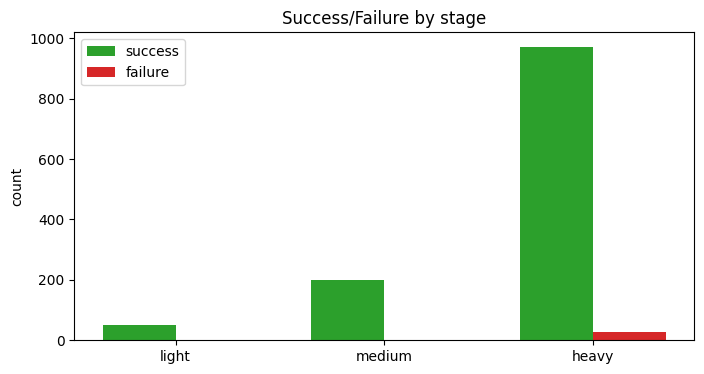

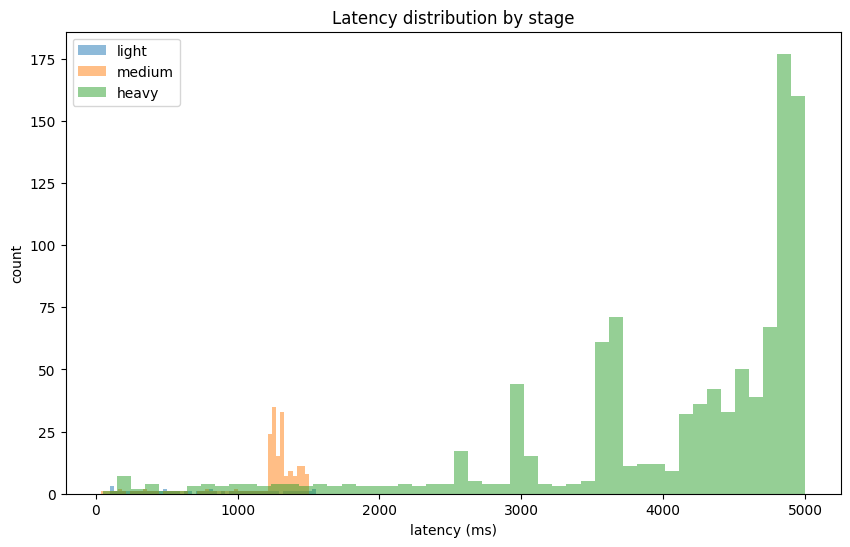

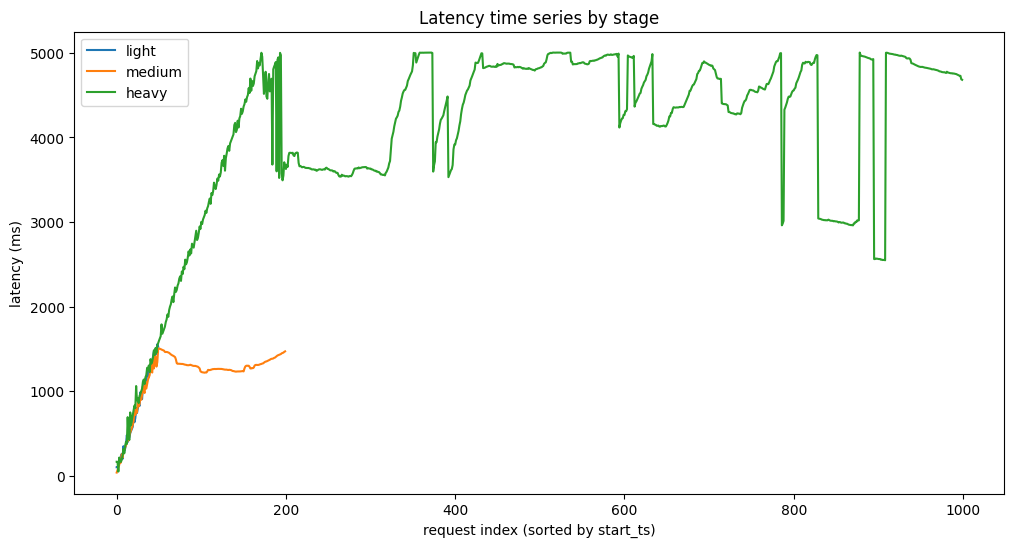

In [20]:
def plot_success_failure(stage_dfs: Dict[str, pd.DataFrame]):
    labels = []
    successes = []
    failures = []
    for k, df in stage_dfs.items():
        labels.append(k)
        successes.append(int(df["success"].sum()))
        failures.append(int((~df["success"]).sum()))

    x = range(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x, successes, width, label="success", color="tab:green")
    ax.bar([i + width for i in x], failures, width, label="failure", color="tab:red")
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(labels)
    ax.set_ylabel("count")
    ax.set_title("Success/Failure by stage")
    ax.legend()
    plt.show()


def plot_latency_histograms(stage_dfs: Dict[str, pd.DataFrame]):
    fig, ax = plt.subplots(figsize=(10, 6))
    bins = 50
    for k, df in stage_dfs.items():
        latencies = df["latency_ms"]
        ax.hist(latencies, bins=bins, alpha=0.5, label=k)
    ax.set_xlabel("latency (ms)")
    ax.set_ylabel("count")
    ax.set_title("Latency distribution by stage")
    ax.legend()
    plt.show()


def plot_latency_timeseries(stage_dfs: Dict[str, pd.DataFrame], max_points: int = 1000):
    fig, ax = plt.subplots(figsize=(12, 6))
    for k, df in stage_dfs.items():
        # 時系列として start_ts をソートしてプロット
        series = df.sort_values("start_ts")["latency_ms"].reset_index(drop=True)
        if len(series) > max_points:
            series = series.sample(max_points).reset_index(drop=True)
        ax.plot(series, label=k)
    ax.set_xlabel("request index (sorted by start_ts)")
    ax.set_ylabel("latency (ms)")
    ax.set_title("Latency time series by stage")
    ax.legend()
    plt.show()


# プロット実行
plot_success_failure(stage_dfs)
plot_latency_histograms(stage_dfs)
plot_latency_timeseries(stage_dfs)

## Notes and run guidance

- `heavy` ステージはローカル開発マシンや API サーバに負荷をかけます。まずは `light` と `medium` を実行して問題がないことを確認してください。
- API のエンドポイントが異なる場合は `API_URL` を変更してください。
- 必要に応じて `max_workers` を調整してください（デフォルトは heavy=200）。
- 実行中に多数の失敗が出る場合、サーバーのログやリソース使用率を確認してください。